# CNN visualization of layer activations

Using TensorFlow 2.0 and Keras

Based on the CIFAR-10 deep neural network prepared in the CnnCifar10 notebook ([HTML](CnnCifar10.html) / [Jupyter](CnnCifar10.ipynb)), let's try simple visualization techniques.

__Learning goals:__
- Visualize intermediate layers of a CNN
- Visualize activation maps

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, models
import tensorflow as tf
import seaborn as sns

In [2]:
if True:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Data - CIFAR-10

Images are normalized to $[0, 1]$

In [37]:
(xTrain, yTrain),(xTest, yTest) = datasets.cifar10.load_data()
xTrain = xTrain / 255.
xTest  = xTest  / 255.

classNames = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

xTrain.shape, xTest.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

# Model

In [4]:
model0 = models.load_model('models/CIFAR-10_CNN5.h5')
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

# Helpers

In [5]:
def predictUntilLayer(model, layerIndex, data):
    """ Execute prediction on a portion of the model """
    intermediateModel = models.Model(inputs=model.input,
                                 outputs=model.layers[layerIndex].output)
    return intermediateModel.predict(data)

def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None,
               vmin=None, vmax=None, cbar=True):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, 
                     fmt=fmt, vmin=vmin, vmax=vmax, cbar=cbar, cmap=plt.cm.bwr, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotOutputs(numConvo, numCols, samples, originals, labels):
    """ Plot a layer output on selected samples """
    numRowsPerSample = int(np.ceil(numConvo / numCols))
    numRows = len(originals) * numRowsPerSample
    fig, axes = plt.subplots(numRows, numCols + 1, figsize=((numCols + 1) * 2, numRows * 2))
    axes = axes.ravel()
    for i, sample in enumerate(samples):
        ax = axes[i * (numRowsPerSample * (numCols + 1))]
        ax.imshow(originals[i])
        ax.set_title(labels[i])
        if(i == 0): 
            ax.xaxis.tick_top()
        for row in range(numRowsPerSample):
            for col in range(numCols):
                c = row * numCols + col
                ax = axes[(i * numRowsPerSample + row) * (numCols + 1) + col + 1]
                ax.imshow(samples[i,:, :, c], cmap='gray')
                ax.set_title('Conv #' + str(c))
                if(i == 0): 
                    ax.xaxis.tick_top()
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)

# Convolution layer #0 activation

Convolution layer #0 is connected to the 32x32, single channel image input. There are 6 convolutions in this layer.

Let's draw the layer's convolution units' coefficients as heat maps:

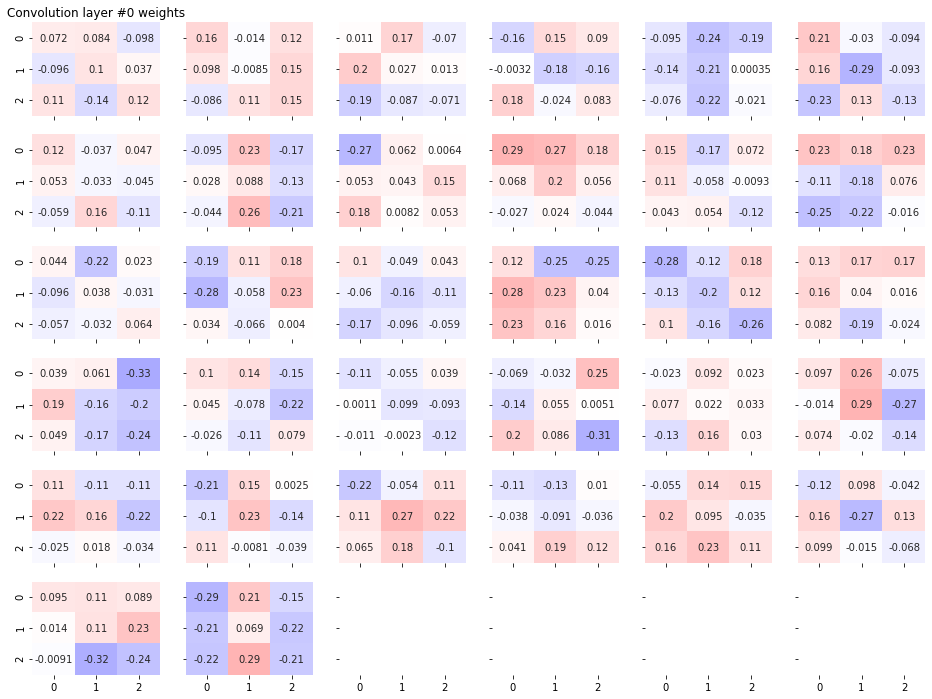

In [6]:
weights0 = model0.get_weights()

fig, axes = plt.subplots(6, 6, figsize=(16, 12), sharex=True, sharey=True)
for i in range(32):
    ax = axes.ravel()[i]
    plotHeatMap(weights0[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("Convolution layer #0 weights");
plt.setp(axes, frame_on=False);

It is quite difficult to extract information from that many displays with so many figures.

It is also difficult to evaluate the impact of each neuron unit given the connections to previous and following layers.

## Sample set to compute activations

Above display of weights is limited in useful information about the network.

Many visualization technics are using some sample set of images to inspect the activations within the network

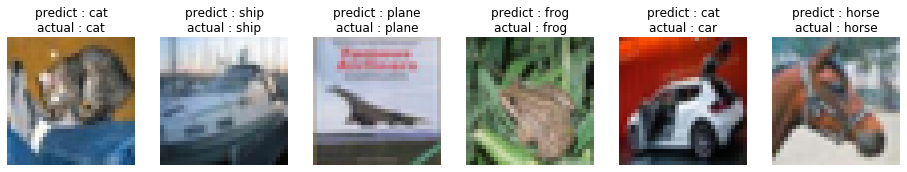

In [52]:
selectedSampleIndexes = [0, 2, 3, 4, 6, 17]
selectedSamples = xTest[selectedSampleIndexes]
selectedLabels = [classNames[yTest[i][0]] for i in selectedSampleIndexes]
preds = np.argmax(model0.predict(selectedSamples), axis=1)
selectedPredictions = [classNames[p] for p in preds]

fig, axes = plt.subplots(1, len(selectedSampleIndexes), figsize=(16, 7))
for ax, sample, estLabel, trueLabel in zip(axes, selectedSamples, selectedPredictions, selectedLabels):
    ax.imshow(sample)
    ax.set_title("predict : %s\nactual : %s" % (estLabel, trueLabel))
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

Note the horse on the right is wrongly labeled dog by the classifier.

In [53]:
sampleAtLayer0 = predictUntilLayer(model0, 0, selectedSamples)
sampleAtLayer0.shape

(6, 30, 30, 32)

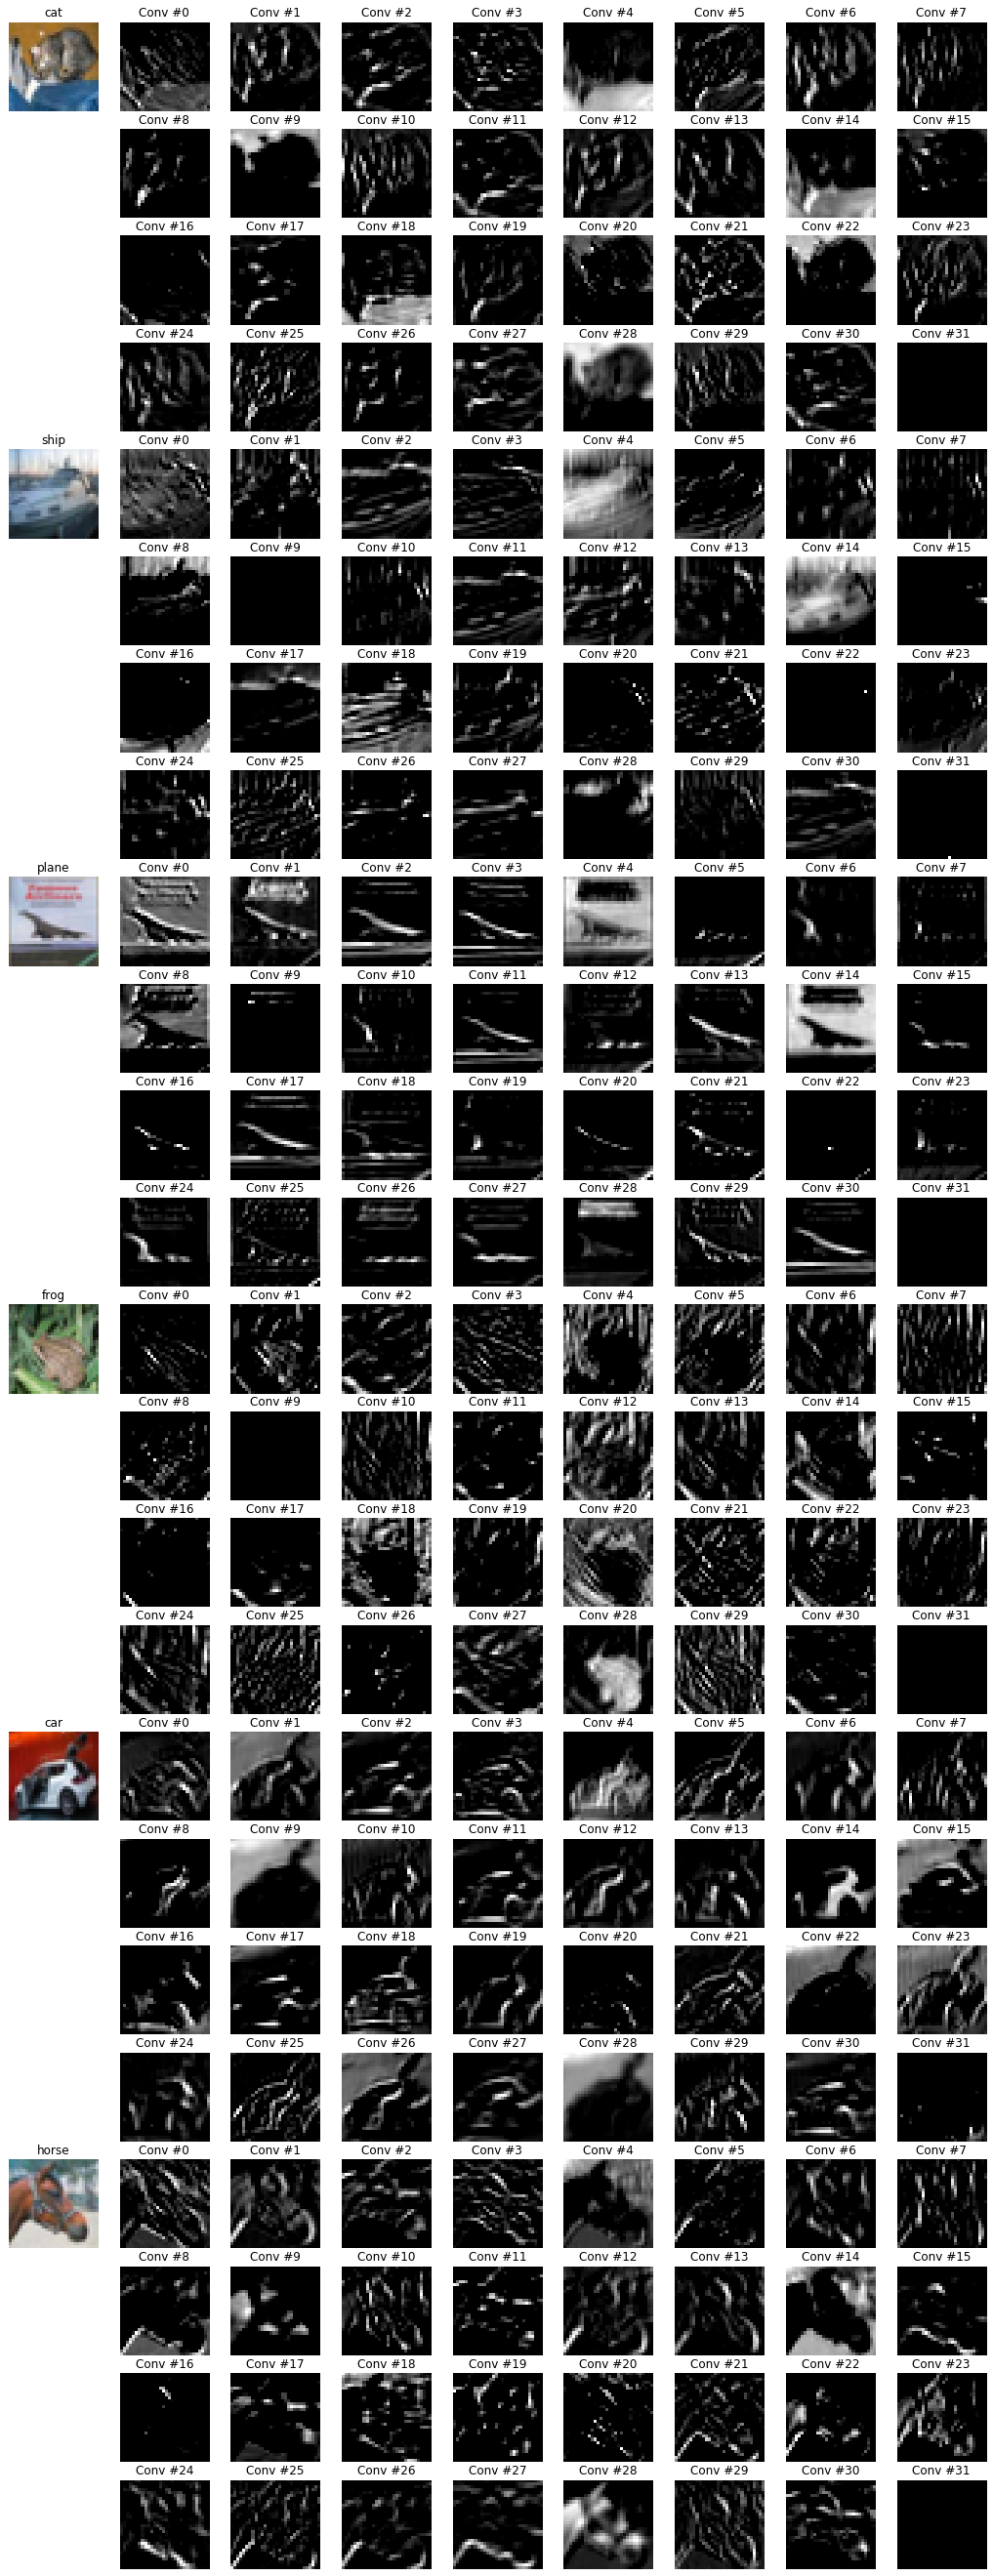

In [54]:
plotOutputs(32, 8, sampleAtLayer0, selectedSamples, selectedLabels)

We may observe that some neurons are focusing on edges like #3, #4, #8

Here again, the information load is high.

## Layer #0 dropout activations

In [10]:
sampleAtLayer0drop = predictUntilLayer(model0, 1, selectedSamples[0:2])
sampleAtLayer0drop.shape

(2, 15, 15, 32)

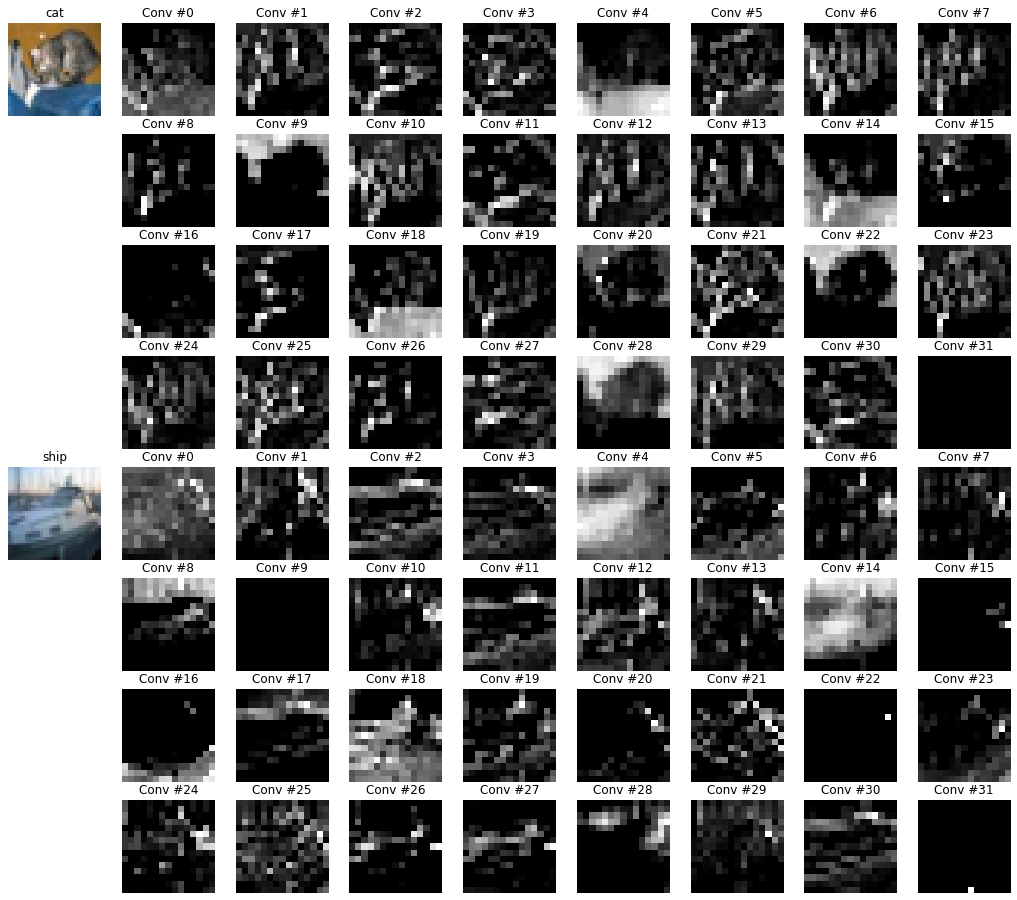

In [11]:
plotOutputs(32, 8, sampleAtLayer0drop, selectedSamples[0:2], selectedLabels[0:2])

As expected, the average drop out is acting as a low pass filter and a downsampler.

# Convolution layer #1 activation

Convolution layer #1 is connecter to the #0 by an average pooling 2x2 (halving the size of the image on each of the 2 dimensions). It is made of 64 convolutions connected to each of the 6 inputs.

In [12]:
weights0[2].shape

(3, 3, 32, 64)

In [13]:
sampleAtLayer1 = predictUntilLayer(model0, 2, selectedSamples)
sampleAtLayer1.shape

(6, 13, 13, 64)

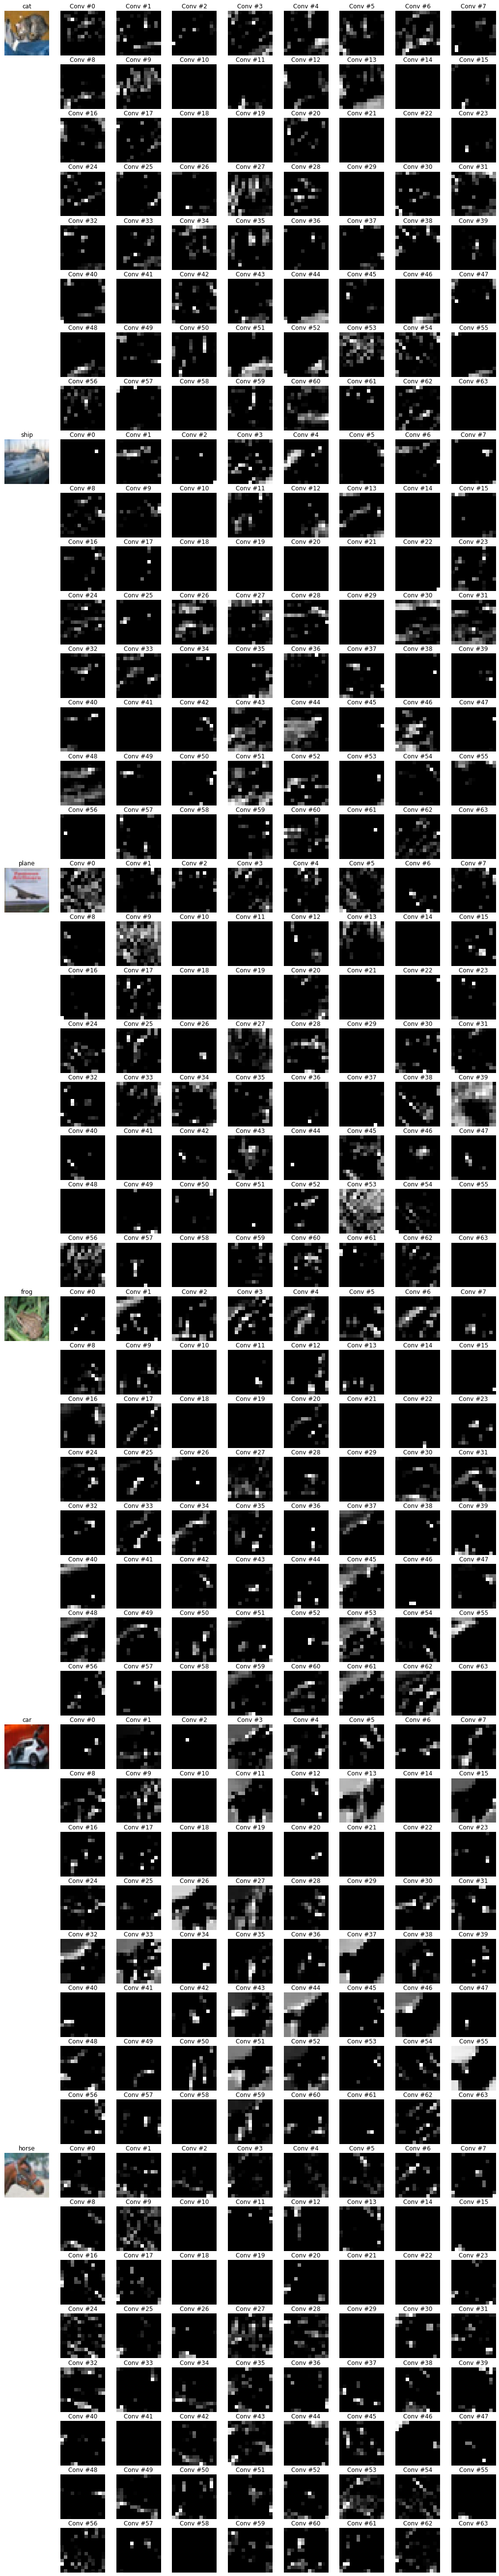

In [55]:
plotOutputs(64, 8, sampleAtLayer1, selectedSamples, selectedLabels)

We see that at the output of the second convolutional layer, the filters are focusing on some more detailed par of the digits. But it is becomes harder to exactly state what is the focus of each filter.

The jet plane with its very sharp edges is the easiest to read out as the edges appear on some of the filters' activations.

# Conclusion

Activation maps are a nice exploration tools. However, their interpretability is limited to the first couple of layers. In the following notebook ([HTML](CnnVisualization-2-SaliencyMaps.html) / [Jupyter](CnnVisualization-2-SaliencyMaps.ipynb)), we will experiment some other techniques based on gradient in order to get more consolidated view of the hidden layers.

## References

1. [Tensorflow tutorial for CNN](https://www.tensorflow.org/tutorials/images/cnn)